# Provenance Test
### Sefi Potashnik

## Introduction - Task 1 definition

The following dataset contains a time-series of 50 stocks (01/2007 - 06/2017) traded in the US market. 
The data is composed of the following columns - 
effective_date, security_id (the is the stock’s identifier) , adjusted_price, opening_price, close_price, highest_price, lowest_price, volume. 

Your tasks are:
Choose a dimensionality reduction algorithm and apply it on the ‘adjusted_price' of all the stocks. Cluster the different stocks in your dataset using this procedure and make sure to label the different stocks. Plot your results


### Sketching my approach
The basic idea: A specific stock s is a point in the space of all its time measurements. We will see if there is a reasonable dimensionality reduction, i.e. one such that the explained variance in the first few dimensions will be sufficiently high. That is, we would like to express a stock as a linear combination of time measurements.

1. data import: import data and prepare dataframe.
2. preprocessing: decide how to deal with missing data and scaling / transforming
3. PCA: check first few dimensions wrt the explained variance. 
4. Cluster PCA results. 

#### 1. Data imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
#%matplotlib inline

In [2]:
df = pd.read_csv('securities_history.csv')
X = df[['effective_date', 'security_id', 'adjusted_price']]
table = X.pivot(index='security_id', columns='effective_date', values='adjusted_price')
table.head(10)

effective_date,2007-01-02,2007-01-03,2007-01-04,2007-01-05,2007-01-08,2007-01-09,2007-01-10,2007-01-11,2007-01-12,2007-01-16,...,2018-01-16,2018-01-17,2018-01-18,2018-01-19,2018-01-22,2018-01-23,2018-01-24,2018-01-25,2018-01-26,2018-01-29
security_id,,,,,,,,,,,,,,,,,,,,,
US0028962076,NaN,54.52,56.11,56.79,56.75,57.66,58.46,59.22,59.96,60.36,...,18.59,18.86,18.95,19.92,22.43,23.06,21.85,21.51,22.21,21.87
US02319V1035,NaN,1.16,1.16,1.13,1.15,1.14,1.13,1.16,1.19,1.18,...,6.75,6.78,6.76,6.86,6.80,6.71,6.87,6.82,6.90,6.82
US0325111070,NaN,39.11,37.99,38.25,38.29,38.30,37.51,37.45,38.74,38.39,...,58.55,58.97,58.29,58.20,60.72,60.94,61.43,61.49,61.84,60.96
US04351G1013,NaN,11.94,12.00,11.31,11.09,11.20,11.54,11.90,11.82,11.51,...,2.11,2.12,2.11,2.17,2.20,2.23,2.18,2.18,2.25,2.29
US12653C1080,NaN,27.69,26.87,26.74,27.59,27.70,27.89,28.48,29.45,28.94,...,14.63,14.88,14.64,14.29,14.51,14.65,14.67,14.71,14.45,13.84
US1651671075,NaN,22.27,22.18,22.37,22.39,22.33,22.08,21.84,22.44,22.35,...,4.14,4.09,3.99,3.95,3.97,4.07,4.08,3.96,4.00,3.88
US1921085049,NaN,47.90,46.30,44.70,44.70,42.00,42.60,42.70,44.50,43.00,...,8.60,8.61,8.33,8.33,8.48,8.40,8.59,8.33,8.46,8.06
US20825C1045,NaN,27.13,26.28,26.82,27.17,26.46,25.67,24.59,25.39,24.98,...,58.84,59.86,59.76,59.75,60.67,60.47,60.49,59.48,60.39,59.66
US21871N1019,NaN,13.82,13.70,13.21,13.44,13.47,13.56,13.65,13.88,13.91,...,22.54,22.22,21.98,22.34,22.43,22.24,22.57,22.78,24.03,23.06


#### 2. Preprocessing

Missing Values:

Columns: we'll look at the distribution of NaN over the columns.
a quick glance in the table above reveals that there for the firs time point that has almost no measurements. Clearly it are not useful to us in characterizing the stocks. Decision: We will drop columns that has above 95% NaN values. This is an arbitrary vlue and open to discussion.

Rows: Several stocks do not have later time measurements and others do not have early ones,  i.e. they were not at the market at these times. We will however not drop them because we would like to examine their behavior in their limited interval. I think that in our context it makes sense to impute their value with the previous or forward price value, given the interpretation of no change - If you were to enter the market in these NaN times, you would neither gain nor lose by investing in that stock. 
This strategy will also carry over to any momentarily, accidental non measurements in traded stocks (i.e, holidays), under the assumption that stock prices do not vary sharply but gradually over time. 



Scaling / Transforming (to 'returns' - a discussion).

Stocks change over time (non-stationary process), so the moments (no pun intended) change over time too. Correlations between prices could be misleading. we remove trends by switching to returns: i.e, looking at difference of prices, divided by prices. This also guarantees normalization:

return(i) = (price(i)-price(i-1)) / price(i)

However, I am not entirely sure whether we should transform to returns or not. Given a sufficiently long time series, as we are given here now (2770 times), we can interpret it as characterizing the stock. As far as I understand, this is open to debate.

So, I will explore both possibilities. First, as we will see below, after performing PCA on the 'returns' features, the cumulative explained variance of the first (most significant) 2 dimensions is quite low: nearly 20%. This means that clustering according to these results is uninterpretable. 

Thus, I revert to the second (original) performing PCA on the stock prices (after scaling). the cumulative explained variance of the first (most significant) 2 dimensions is very high: nearly 99%. As I said, I am not sure it is not coincidental.  In the case it is interpretable, it means that we can characterize the stocks in terms of 2 dimesnions instead of 2770 ones. Analysis of several stocks from different clusters follows below, after clustering.

In [3]:
print(table.isnull().sum())
percentToDropColumn = 0.95
t1 = table.dropna(axis=1, thresh=table.shape[0] * percentToDropColumn)
t2 = t1.ffill(axis=1) # for stocks that have no future measurements.
stockPrices = t2.bfill(axis=1) # for stocks that have no past measurements.
stockReturns = stockPrices.pct_change(axis=1) # transform to returns
stockReturns = stockReturns.dropna(axis=1, thresh=table.shape[0] * percentToDropColumn) #first column now has no returns

effective_date
2007-01-02    49
2007-01-03     1
2007-01-04     1
2007-01-05     1
2007-01-08     1
2007-01-09     1
2007-01-10     1
2007-01-11     1
2007-01-12     1
2007-01-16     1
2007-01-17     1
2007-01-18     1
2007-01-19     1
2007-01-22     1
2007-01-23     1
2007-01-24     1
2007-01-25     1
2007-01-26     1
2007-01-29     1
2007-01-30     1
2007-01-31     1
2007-02-01     1
2007-02-02     1
2007-02-05     1
2007-02-06     1
2007-02-07     1
2007-02-08     1
2007-02-09     1
2007-02-12     1
2007-02-13     1
              ..
2017-12-14     2
2017-12-15     2
2017-12-18     2
2017-12-19     2
2017-12-20     2
2017-12-21     2
2017-12-22     2
2017-12-26     2
2017-12-27     2
2017-12-28     2
2017-12-29     2
2018-01-02     2
2018-01-03     2
2018-01-04     2
2018-01-05     2
2018-01-08     2
2018-01-09     2
2018-01-10     2
2018-01-11     2
2018-01-12     2
2018-01-16     2
2018-01-17     2
2018-01-18     2
2018-01-19     2
2018-01-22     2
2018-01-23     2
2018-01-24     2

#### 3. PCA

In [4]:
def PerformPCA(s, pd):
    model = PCA(n_components=2)           
    pca = model.fit_transform(pd)                  
    print("cumulative explained variance of PCA vectors of " + s)
    print(model.explained_variance_ratio_.cumsum())
    return pca

In [5]:
pcaForStockReturns = PerformPCA("stock returns", stockReturns)
stockPrices = StandardScaler().fit_transform(stockPrices) ##scaling the stock prices 
pcaForStockPrices = PerformPCA("stock prices", stockPrices)

cumulative explained variance of PCA vectors of stock returns
[0.106 0.191]
cumulative explained variance of PCA vectors of stock prices
[0.839 0.989]


#### 4. Clustering
For simplicity re. parameter space, I use KMeans for clustering. The user can choose the number of clusters (default = 4).

In [6]:
plt.rcParams["figure.figsize"] = [15, 15]

def PerformClustering(pca, table, numberOfClusters=4):
    kMeansClassifier = KMeans(n_clusters=numberOfClusters)
    kMeansClassifier.fit(pca)
    y_pred = kMeansClassifier.predict(pca)
    x = pca[:, 0]
    y = pca[:, 1]
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=y_pred)

    #if the labels of the text are disturbing the reader, comment out the next two lines.
    for line in range(0,pcaForStockReturns.shape[0]):
            ax.annotate(table.index[line], (x[line], y[line]))    
    
    securitiesClusterDF = pd.DataFrame(data = np.c_[y_pred, table.index], columns = ['cluster_id', 'security_id'])

    for name, group in securitiesClusterDF.groupby('cluster_id'): 
        print("cluster " + str(name))
        print(group[['security_id']])
        

cluster 0
     security_id
17  US4642878049
18  US46625H1005
24  US6745991058
28  US6819191064
33  US7443201022
34  US78409V1044
41  US8825081040
44  US9113631090
47  US95040Q1040
48  US9581021055
cluster 1
     security_id
43  US88642R1095
cluster 2
     security_id
0   US0028962076
1   US02319V1035
3   US04351G1013
4   US12653C1080
5   US1651671075
6   US1921085049
8   US21871N1019
9   US29273V1008
10  US31787A5074
12  US38059T1060
13  US4470111075
15  US4642868719
19  US48666K1097
20  US5635714059
21  US5658491064
23  US6742151086
25  US67555N2062
26  US6762201068
27  US6806652052
30  US7236641087
31  US73935S1050
36  US81721M1099
38  US8550301027
40  US88033G4073
42  US88554D2053
46  US92922P1066
cluster 3
     security_id
2   US0325111070
7   US20825C1045
11  US3364331070
14  US4601461035
16  US4642872349
22  US59156R1086
29  US6826801036
32  US74340W1036
35  US78464A7303
37  US8447411088
39  US8685363017
45  US91529Y1064
49  US9843321061


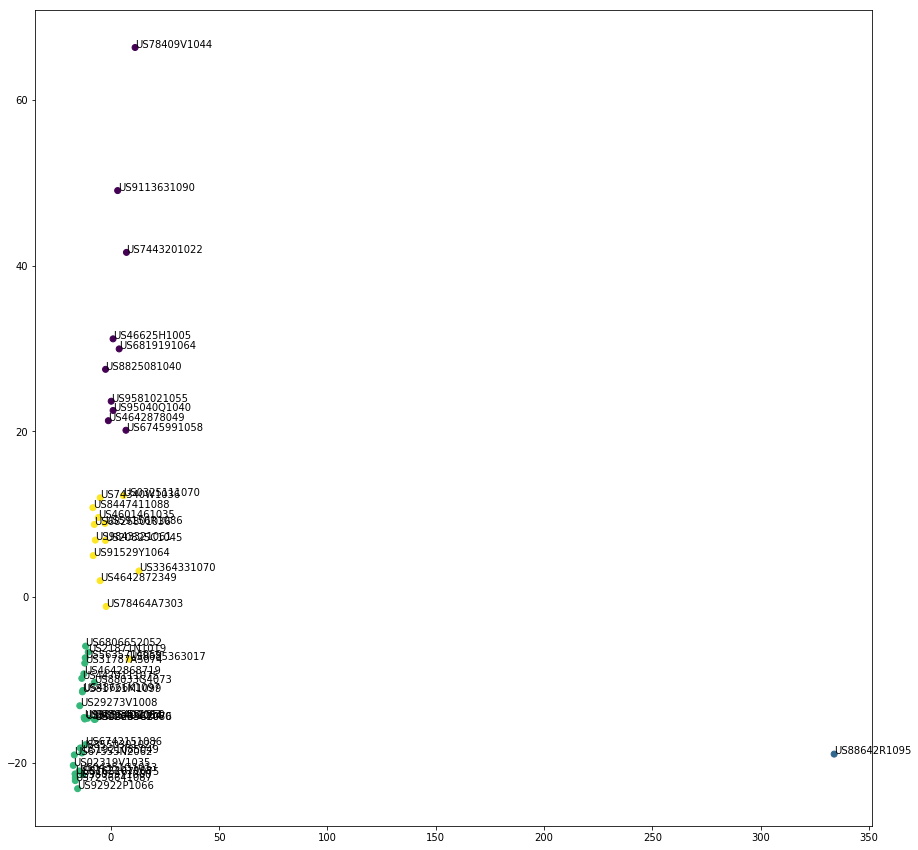

In [7]:
PerformClustering(pcaForStockPrices, table, numberOfClusters = 4)

Let's have a quick look at stock prices changes as a function of time from each cluster (note: I now take the original stock prices from the input file, before scaling), below. We can see the following observations:

1. stock US88642R1095 (cluster 1, orange) declines rapidly, 
2. stock US9581021055 (cluster 2, green) seems to rise slowly. 
3. stock US8685363017 (cluster 3, red) seems to decline slowly. 
4. stock US9843321061 (cluster 0, blue), seems to rise slightly slower, and also is missing the later values, unlike the green stock.

So, all in all, there is some hopeful chance that the interpretation of the PCA reduction is valid. I.e, stocks in the same cluster have similiar linear combinations of prices along times, i.e, they have a similar characterization.


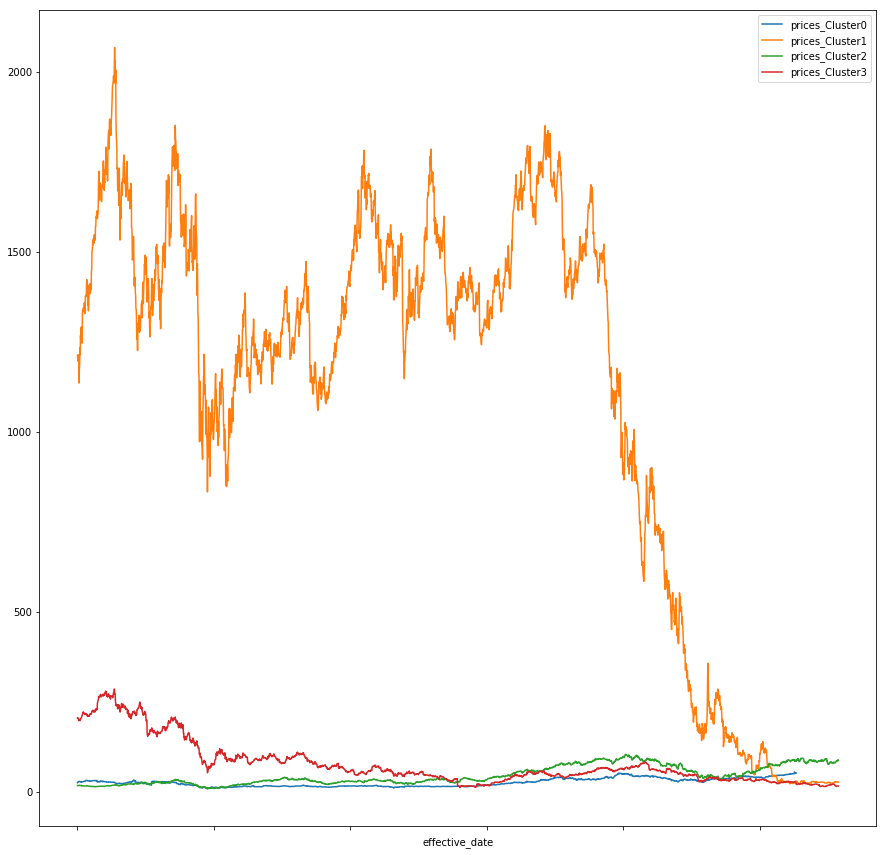

In [8]:
prices_Cluster0 = table.loc['US9843321061']
prices_Cluster1 = table.loc['US88642R1095']
prices_Cluster2 = table.loc['US9581021055']
prices_Cluster3 = table.loc['US8685363017']

prices_df = pd.DataFrame(data={'prices_Cluster0': prices_Cluster0, 
                              'prices_Cluster1': prices_Cluster1,
                              'prices_Cluster2': prices_Cluster2,
                              'prices_Cluster3': prices_Cluster3}, index=prices_Cluster0.index)
prices_df.plot()